In [1]:
import pandas, numpy, seaborn, scipy

In [2]:
import sklearn, sklearn.preprocessing
import statsmodels, statsmodels.stats, statsmodels.stats.multitest

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'xtick.labelsize':20, 
                            'ytick.labelsize':20, 
                            'axes.labelsize':20, 
                            'figure.figsize':(12 * 0.6, 9 * 0.6)})

In [4]:
input_data_file = '/Users/adrian/gd15/research/vigur/data/targeted.2024.eva/EC_72_EVA_All_ION_MODES.xlsx'

In [5]:
basicdf = pandas.read_excel(input_data_file, sheet_name='BASIC_NEG', index_col='SAMPLE')

# Batch and biological replicate 1

In [6]:
wdf = basicdf[basicdf['LCMS_BATCH_Biological_replicate'] == 1]

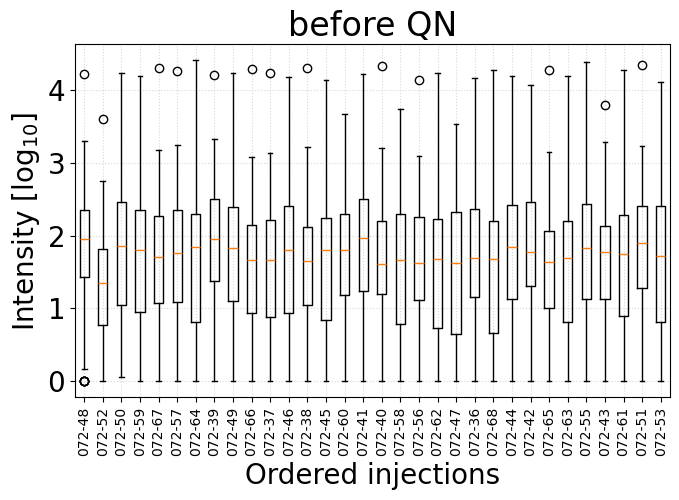

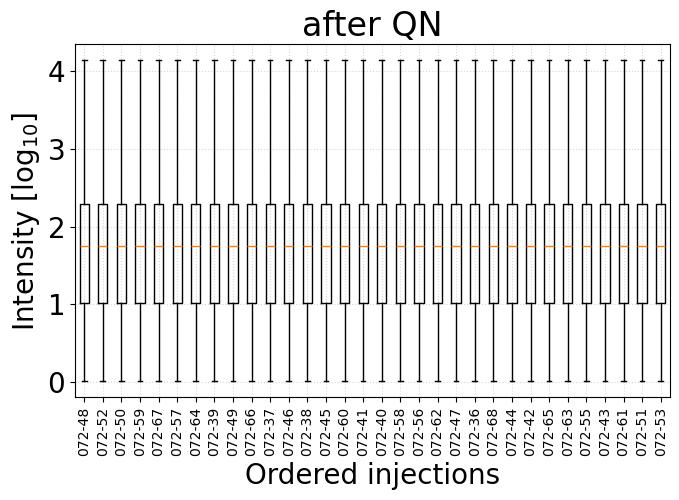

In [7]:
# transform
intensities = wdf.iloc[:, 7:]
intensities.drop('Pool', axis=0, inplace=True)
intensities.drop('072-54', axis=0, inplace=True)

intensities = intensities.transpose()
log10_intensities = numpy.log10(intensities + 1)

#plot
matplotlib.pyplot.boxplot(log10_intensities, labels=intensities.columns)
matplotlib.pyplot.xticks(rotation=90, fontsize=10)
matplotlib.pyplot.xlabel('Ordered injections')
matplotlib.pyplot.ylabel('Intensity [log$_{10}$]')
matplotlib.pyplot.grid(ls=':', alpha=0.5)
matplotlib.pyplot.title('before QN')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

###
### quantile normalization |  taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
###

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(log10_intensities.values, axis=0), 
                             index=log10_intensities.index, 
                             columns=log10_intensities.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
df_qn = log10_intensities.rank(method="min").stack().astype(int).map(df_mean).unstack()

# plot after
matplotlib.pyplot.boxplot(df_qn, labels=df_qn.columns)
matplotlib.pyplot.xticks(rotation=90, fontsize=10)
matplotlib.pyplot.xlabel('Ordered injections')
matplotlib.pyplot.ylabel('Intensity [log$_{10}$]')
matplotlib.pyplot.grid(ls=':', alpha=0.5)
matplotlib.pyplot.title('after QN')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

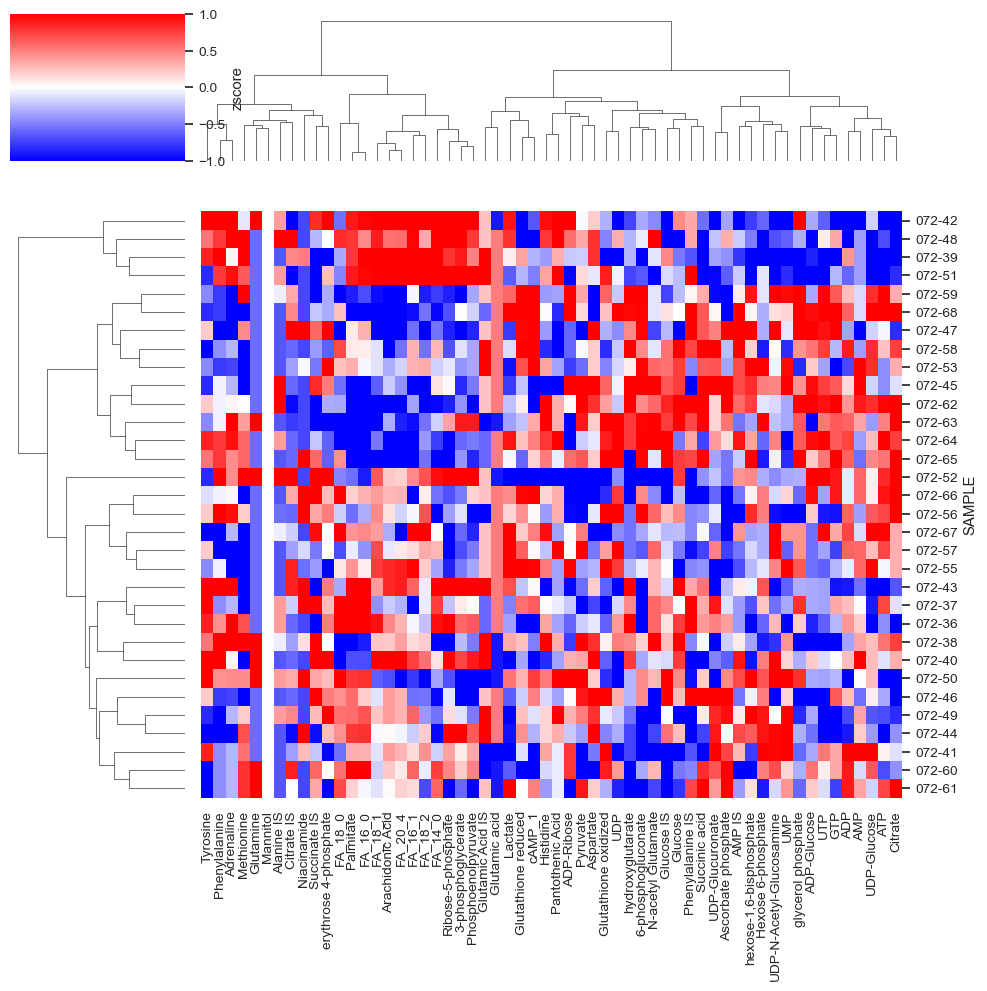

In [8]:
# transpose & scale
t_df_qn = df_qn.transpose()
std_scaler = sklearn.preprocessing.StandardScaler()
df_std = pandas.DataFrame(std_scaler.fit_transform(t_df_qn), columns=t_df_qn.columns, index=t_df_qn.index)

# visualize
linkage_method = 'ward'
distance_metric = 'euclidean'

seaborn.set(font_scale=0.9)
seaborn.clustermap(df_std, 
                   cmap='bwr', col_cluster=True, vmin=-1, vmax=1, 
                   method=linkage_method, metric=distance_metric, 
                   yticklabels=1, xticklabels=1,
                   cbar_kws={'label':'zscore'})
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [9]:
print(df_std['Alanine IS'].mean())
print(df_std['Alanine IS'].std())

4.163336342344337e-17
1.016001016001524


In [10]:
df_std.head()

,Alanine IS,AMP IS,Citrate IS,Glucose IS,Glutamic Acid IS,Phenylalanine IS,Succinate IS,Glutamic acid,Hexose 6-phosphate,Glutamine,...,Phosphoenolpyruvate,erythrose 4-phosphate,Citrate,hydroxyglutarate,Aspartate,glycerol phosphate,Adrenaline,Niacinamide,Tyrosine,N-acetyl Glutamate
SAMPLE,,,,,,,,,,,,,,,,,,,,,
072-48,1.520888,-0.208612,1.095711,-1.494929,0.235322,0.343083,-0.285379,0.507890,-1.186565,-0.577350,...,0.773291,-0.005569,-2.608690,-0.289795,0.807867,-0.319509,1.695610,-0.718964,0.542980,1.433462
072-52,3.158122,0.419128,3.951013,-1.494929,0.235322,-1.319927,1.821349,-0.908759,-0.316467,1.732051,...,1.581852,2.299235,1.174697,-1.898726,-1.703214,-0.319509,0.448314,-0.718964,-0.832365,-2.684188
072-50,0.383365,0.713344,0.328301,1.629362,-2.756008,-0.949421,0.344102,-0.908759,0.671033,1.732051,...,-2.194779,0.263852,-1.599132,-0.289795,0.199341,0.808371,0.448314,1.510970,1.498010,0.281638
072-59,-0.065059,0.084148,0.328301,-0.733256,0.235322,0.036942,-1.474101,0.507890,-0.107114,-0.577350,...,-0.343888,-0.323775,0.318662,1.622946,-1.248970,1.026692,-1.741144,-0.718964,-0.467534,-0.107909
072-67,-0.065059,0.419128,-0.192959,-0.275379,0.235322,-0.470403,0.959444,0.507890,-0.316467,-0.577350,...,-0.852077,-0.005569,0.318662,-0.551635,-2.497145,0.423385,-0.286313,-0.718964,-1.664322,-0.107909


In [11]:
# test
timepoints = [4, 24]
timepoints = [4, 24]
control_label = '0µM'
sample_label = '5 µM epi:nor'
metabolites = df_std.columns

for timepoint in timepoints:
    print('Timepoint {}'.format(timepoint))
    rules = (wdf['TIME'] == timepoint) & (wdf['TREATMENT'] == control_label)
    controls = wdf[rules].index.to_list()
    rules = (wdf['TIME'] == timepoint) & (wdf['TREATMENT'] == sample_label)
    samples = wdf[rules].index.to_list()

    uncorrected = []
    for metabolite in metabolites:
        #print('\t', metabolite)
        existing = [control for control in controls if control in df_std.index]
        x = df_std.loc[existing, metabolite]
        existing = [sample for sample in samples if sample in df_std.index]
        y = df_std.loc[samples, metabolite]

        (statistic, pvalue) = scipy.stats.ttest_ind(x, y)
        if numpy.isnan(pvalue) == True:
            pvalue = 1
        uncorrected.append(pvalue)
        if pvalue < 0.05:
            #print('\t\t', metabolitex.values, y.values, pvalue)
            print('\t', metabolite)
    results = statsmodels.stats.multitest.multipletests(uncorrected, method='fdr_bh')
    print('We found significant metabolites:', sum(results[0]))
    print(results)

    # plot significant
    for i in range(len(metabolites)):
        if results[0][i] == True:
            print(metabolites[i], results[1][i])
            metabolite = metabolites[i]
            a = df_std.loc[controls, metabolite]
            b = df_std.loc[samples, metabolite]
            matplotlib.pyplot.boxplot([a, b])
            matplotlib.pyplot.title('{}; P = {:.3f}'.format(metabolite, results[1][i]))
            matplotlib.pyplot.show()

Timepoint 4
	 Alanine IS
	 Pantothenic Acid
	 ADP
We found significant metabolites: 0
(array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False]), array([0.57658836, 1.        , 0.62977804, 0.91251588, 0.9506447 ,
       0.91251588, 0.95227679, 0.77971643, 0.91251588, 1.        ,
       0.81415988, 1.        , 0.62977804, 1.        , 0.82046403,
       0.77971643, 0.81415988, 0.57658836, 0.77971643, 0.58864564,
       0.77971643, 0.95227679, 0.77971643, 0.77971643, 0.81415988,
       0.78951109, 0.81415988, 1.        , 0.77971643, 0.81415988,
       0.77971643, 1.        , 1.        , 0.62977804,

/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531